# Experiment

## Modules

In [6]:
import sys  
sys.path.insert(1, '/Users/asifahmed/Documents/Codes/MyRecourseProject')

import numpy as np
import sys
import io
import pandas as pd
from models.model_trainer import ModelTrainer
from evaluation.evaluator import Evaluator
from visualization.visualizer import Visualizer
from data_handling.dataset import Dataset
from explainability.recourse_cost_calculator import RecourseCostCalculator
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from statsmodels.nonparametric.kde import KDEUnivariate

def sample_from_distribution(distribution_name, params, size=1):
    if distribution_name == 'normal':
        return np.random.normal(*params, size)
    elif distribution_name == 'uniform':
        return np.random.uniform(*params, size)
    elif distribution_name == 'power_law':
        shape, scale = params
        return (np.random.pareto(shape, size) + 1) * scale
    else:
        raise ValueError("Unsupported distribution type")

def generate_synthetic_data(n_samples=1000, seed=None, distributions=None, gender_proportions=None):
    if seed is not None:
        np.random.seed(seed)

    if gender_proportions is None:
        gender_proportions = [0.5, 0.5]

    genders = np.random.choice([1, 2], size=n_samples, p=gender_proportions)

    if distributions is None:
        raise ValueError("Distributions must be specified")

    X1, X2 = [], []
    for gender in genders:
        dists_X1 = distributions[gender]['X1']
        dists_X2 = distributions[gender]['X2']

        # Sample equally from all distributions for X1 and X2
        X1_samples = np.hstack([sample_from_distribution(dist[0], dist[1], size=n_samples//len(dists_X1)) for dist in dists_X1])
        X2_samples = np.hstack([sample_from_distribution(dist[0], dist[1], size=n_samples//len(dists_X2)) for dist in dists_X2])

        # Select one randomly for each feature
        X1.append(np.random.choice(X1_samples))
        X2.append(np.random.choice(X2_samples))
        
    X1 = np.round(X1).astype(int)
    X2 = np.round(X2).astype(int)

    noise = np.where(genders == 1, 
                        np.random.normal(0, 5, n_samples),
                        np.random.normal(0, 15, n_samples))
    noise = np.round(noise).astype(int)    
    
    gender_effect = np.where(genders == 1, .1, -.08)

    decision_boundary = 0.5 * X1 + 0.3 * X2 + 0.2 * gender_effect+ noise
    y = (decision_boundary > np.median(decision_boundary)).astype(int)

    data = pd.DataFrame({'X1': X1, 'X2': X2, 'Gender': genders, 'y': y})
    data.to_csv('synthetic_data.csv', index=False)
    print("Synthetic data with bias generated and saved to 'synthetic_data.csv'.")

    return data

def load_and_preprocess_data(filepath, sample_size = 1000, target_column='y'):
    data_instance = Dataset(target_column=target_column)
    data_instance.load_csv(filepath)
    data_instance.encode_categorical_columns()
    sensitive_features = data_instance.data['Gender']
    data_instance.select_features(['y', 'X1', 'X2'])
    data_instance.sample_data(sample_size)
    return data_instance, sensitive_features

def split_and_scale_data(data_instance):
    trainer = ModelTrainer()
    X_train, X_test, y_train, y_test = trainer.split_data(data_instance.data, target_column='y')
    X_train_scaled, X_test_scaled = trainer.scale_features(X_train, X_test)
    return X_train_scaled, X_test, X_test_scaled, y_train, y_test

def train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, model_type='logistic_regression'):
    trainer = ModelTrainer()
    model = trainer.train(model_type, X_train_scaled, y_train)
    evaluator = Evaluator(model, X_test_scaled, y_test)
    evaluation_report = evaluator.report()
    return model, evaluation_report

def visualize_misclassified_data(model, X_test, X_test_scaled, y_test, sensitive_features, 
                                 feature_names = ('X1', 'X2'), title='Logistic Regression Plot'):
    y_pred = model.predict(X_test_scaled)
    
    # Identify gender from sensitive features for analysis
    gender_test = sensitive_features.loc[X_test.index]
    
    # Calculate false negatives
    false_negatives = (y_test == 1) & (y_pred == 0)
    false_negative_counts = gender_test[false_negatives].value_counts()
    print("False Negative Counts by Gender:")
    print(false_negative_counts)

    # Find misclassified examples
    misclassified = y_test != y_pred
    X_misclassified = X_test_scaled[misclassified]  
    y_misclassified = y_test[misclassified]  
    gender_misclassified = gender_test[misclassified]

    # Visualize decision boundaries and misclassified points
    visualizer = Visualizer(model, X_misclassified, y_misclassified, 
                            X_original=X_test_scaled[misclassified],
                            sensitive_attr=gender_misclassified)
    visualizer.plot_decision_boundary_interactive(feature_names, title)

def get_false_negatives(model,X_test, X_test_scaled, y_test, sensitive_features):
    y_pred = model.predict(X_test_scaled)
    gender_test = sensitive_features[X_test.index]
    false_negatives = (y_test == 1) & (y_pred == 0)
    false_negative_counts = gender_test[false_negatives].value_counts()
    return false_negatives, false_negative_counts

def ranking_false_negatives_data_points(model, X_test, X_test_scaled, y_test, sensitive_features, percentage_to_help, top_k=10):
    y_pred = model.predict(X_test_scaled)
    false_negatives = (y_test == 1) & (y_pred == 0)
    X_false_negatives = X_test_scaled[false_negatives]
    y_false_negatives = y_test[false_negatives]
    sensitive_features_test = sensitive_features.loc[X_test.index]
    gender_false_negatives = sensitive_features_test[false_negatives]

    recourse_calculator = RecourseCostCalculator(model)

    recourse_without_rewards = recourse_calculator.rank_data_points(X_false_negatives, gender_data=gender_false_negatives)
    # print('Recourse Without Rewards')
    # print(recourse_without_rewards)
    # print()

    # Identify females to help based on the specified percentage
    females_to_help = recourse_calculator.identify_females_to_help(recourse=recourse_without_rewards, percentage_to_help=percentage_to_help)
    # print("Females To Help")
    # print(females_to_help)
    # print()

    # Determine which data points to keep (males or the selected females)
    females_to_help_indices = females_to_help['Index']
    condition = ((recourse_without_rewards['Gender'] == 1) |  # Keep all males
                 (recourse_without_rewards['Index'].isin(females_to_help_indices)))  # Keep selected females
    recourse_without_unwanted_females = recourse_without_rewards[condition]
  

    # Apply gender rewards to the filtered dataset
    recourse_with_rewards = recourse_calculator.apply_gender_rewards(recourse_without_unwanted_females)
    print(f'\nFinal Top {top_k} Ranked datapoints')    
    print(recourse_with_rewards[:top_k])
    print()

    return recourse_without_rewards,recourse_with_rewards

def generate_plot_title(sample_size, distributions):
    title = f"Sample Size {sample_size}\n"
    dist_descriptions = []

    # Create descriptions for each gender's distribution
    for gender, dist_info in distributions.items():
        gender_text = "Male: " if gender == 1 else "Female: "
        features_text = []
        for feature, dist_list in dist_info.items():
            descriptions = ', '.join([f"{dist[0]} ({dist[1][0]}, {dist[1][1]})" for dist in dist_list])
            features_text.append(f"{feature}: {descriptions}")
        # Combine feature descriptions for each gender
        dist_descriptions.append(gender_text  + "\n".join(features_text))

    title += "\n\n".join(dist_descriptions)
    return title


def plot_histograms(data, title='Histogram'):
        plt.figure(figsize=(10, 4))
        sns.histplot(data, kde=True, bins=30, color='blue', edgecolor='black')
        plt.xlabel('Cost')
        plt.ylabel('Frequency')
        # plt.title(title)
        plt.legend(title=title)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def plot_side_by_side_histograms(datasets, titles, legend_labels = None, bins=30, figsize=(10, 6)):
    n = len(datasets)
    
    plt.figure(figsize=(figsize[0] * n, figsize[1]))
    
    for i, data in enumerate(datasets):
        data = data['Recourse Cost'] 
        ax = plt.subplot(1, n, i+1)

        label = legend_labels[i] if legend_labels and len(legend_labels) > i else f"Figure {i+1}"

        # Plotting the histogram with a label
        sns.histplot(data, kde=True, bins=bins, label=label, ax=ax)
        ax.set_title(titles[i])
        ax.set_xlabel('Cost')
        ax.set_ylabel('Frequency')
        plt.xticks(rotation=45)
        ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()


def plot_gender_pie_charts(datasets, gender_column='Gender', titles=None):
    n = len(datasets)
    
    min_width = 8  # Minimum width for the figure
    width_per_plot = max(4, min_width / max(n, 1))  # Calculate width per plot with a minimum
    fig_width = width_per_plot * n  # Total width of the figure
    
    fig, axes = plt.subplots(1, n, figsize=(fig_width, 6))  # Use the calculated figure width
        
    if n == 1:
        axes = [axes]

    # Loop through the datasets and their respective titles if provided
    for ax, data, title in zip(axes, datasets, titles or [''] * n):
        # Count the number of occurrences of each gender
        gender_counts = data[gender_column].value_counts()
        labels = ['Male' if x == 1 else 'Female' for x in gender_counts.index]

        ax.pie(gender_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e'])
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax.set_title(title or 'Top K Gender Distribution')

    # Show the plot
    plt.tight_layout()
    plt.show()


def plot_custom_grid_of_histograms(top_k_before_after, top_k_male_list, top_k_female_list, titles, figsize=(30,20)):
    fig, axs = plt.subplots(4, 6, figsize=figsize)

    all_data = np.concatenate([df['Recourse Cost'] for df in top_k_before_after + top_k_male_list + top_k_female_list])
    x_min = np.min(all_data)
    x_max = np.max(all_data)
    y_max = max([df['Recourse Cost'].value_counts().max() for df in top_k_before_after + top_k_male_list + top_k_female_list])

    for i in range(6):
        for j, dataset in enumerate([top_k_before_after, top_k_male_list, top_k_female_list]):
            data = dataset[i]['Recourse Cost']
            ax = axs[j, i]
            sns.histplot(data, kde=True, ax=ax, color=['blue', 'green', 'red'][j], bins=10)
            ax.set_title(titles[j * 6 + i])
            ax.set_xlim(x_min, x_max) 
            ax.set_ylim(0, y_max * 1.1)

    for i in range(6):
        ax_pie = axs[3, i]  # Fourth row, position corresponds to the histogram above
        gender_counts = top_k_before_after[i]['Gender'].value_counts()
        labels = ['Males' if idx == 1 else 'Females' for idx in gender_counts.index]
        colors = ['#1f77b4' if label == 'Males' else '#ff7f0e' for label in labels]
        ax_pie.pie(gender_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
        ax_pie.set_title(titles[i] + ' - Gender Distribution')

    plt.tight_layout()
    plt.show()


def analyze_recourse_cost_distribution(data):
    clean_data = data[np.isfinite(data)]  # Remove any infinite or NaN values from the data

    # Perform Shapiro-Wilk Test for normality
    shapiro_test = stats.shapiro(clean_data)
    print("Shapiro-Wilk Test results:")
    print("Statistic:", shapiro_test.statistic, "P-value:", shapiro_test.pvalue)

    # Perform Anderson-Darling Test for normality
    try:
        anderson_test = stats.anderson(clean_data)
        print("\nAnderson-Darling Test results:")
        print("Statistic:", anderson_test.statistic)
        for i in range(len(anderson_test.critical_values)):
            sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
            print(f"Significance level: {sl}%, Critical value: {cv}, {'Fail to reject' if anderson_test.statistic < cv else 'Reject'} the hypothesis of normality")
    except Exception as e:
        print("Error in Anderson-Darling Test:", e)


def experiment(params):
    buffer = io.StringIO()
    old_stdout = sys.stdout
    sys.stdout = buffer 

    dataset_size = params['dataset_size']
    sample_size = params['sample_size']
    model_type = params['model_type']
    percentage_to_help = params['percentage_to_help']
    top_k = int(sample_size / 100) 
    filepath = params['filepath']
    distributions = params['distributions']
    gender_proportions = params['gender_proportions']

    data = generate_synthetic_data(dataset_size, distributions=distributions, gender_proportions=gender_proportions)

    data_instance, sensitive_features= load_and_preprocess_data(filepath=filepath, sample_size=sample_size)
    X_train_scaled, X_test, X_test_scaled, y_train, y_test = split_and_scale_data(data_instance=data_instance)
    model, evaluation_report = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, model_type = model_type)
    # visualize_misclassified_data(model, X_test, X_test_scaled, y_test, sensitive_features)
    false_negatives, false_negative_counts = get_false_negatives(model,X_test, X_test_scaled, y_test, sensitive_features)
    print(false_negative_counts)

    recourse_without_rewards,recourse_with_rewards = ranking_false_negatives_data_points(model, X_test, X_test_scaled, 
                                                                                        y_test, sensitive_features, 
                                                                                        percentage_to_help,
                                                                                        top_k= top_k)

    sys.stdout = old_stdout
    captured_output = buffer.getvalue()

    # print("Experiment completed with captured output:")
    # print(captured_output)

    return recourse_without_rewards, recourse_with_rewards

## Experiment 1

Only the sample size is changed in this experiment. In this experiment, we observed how changing the sample size affects the top k data distribution.

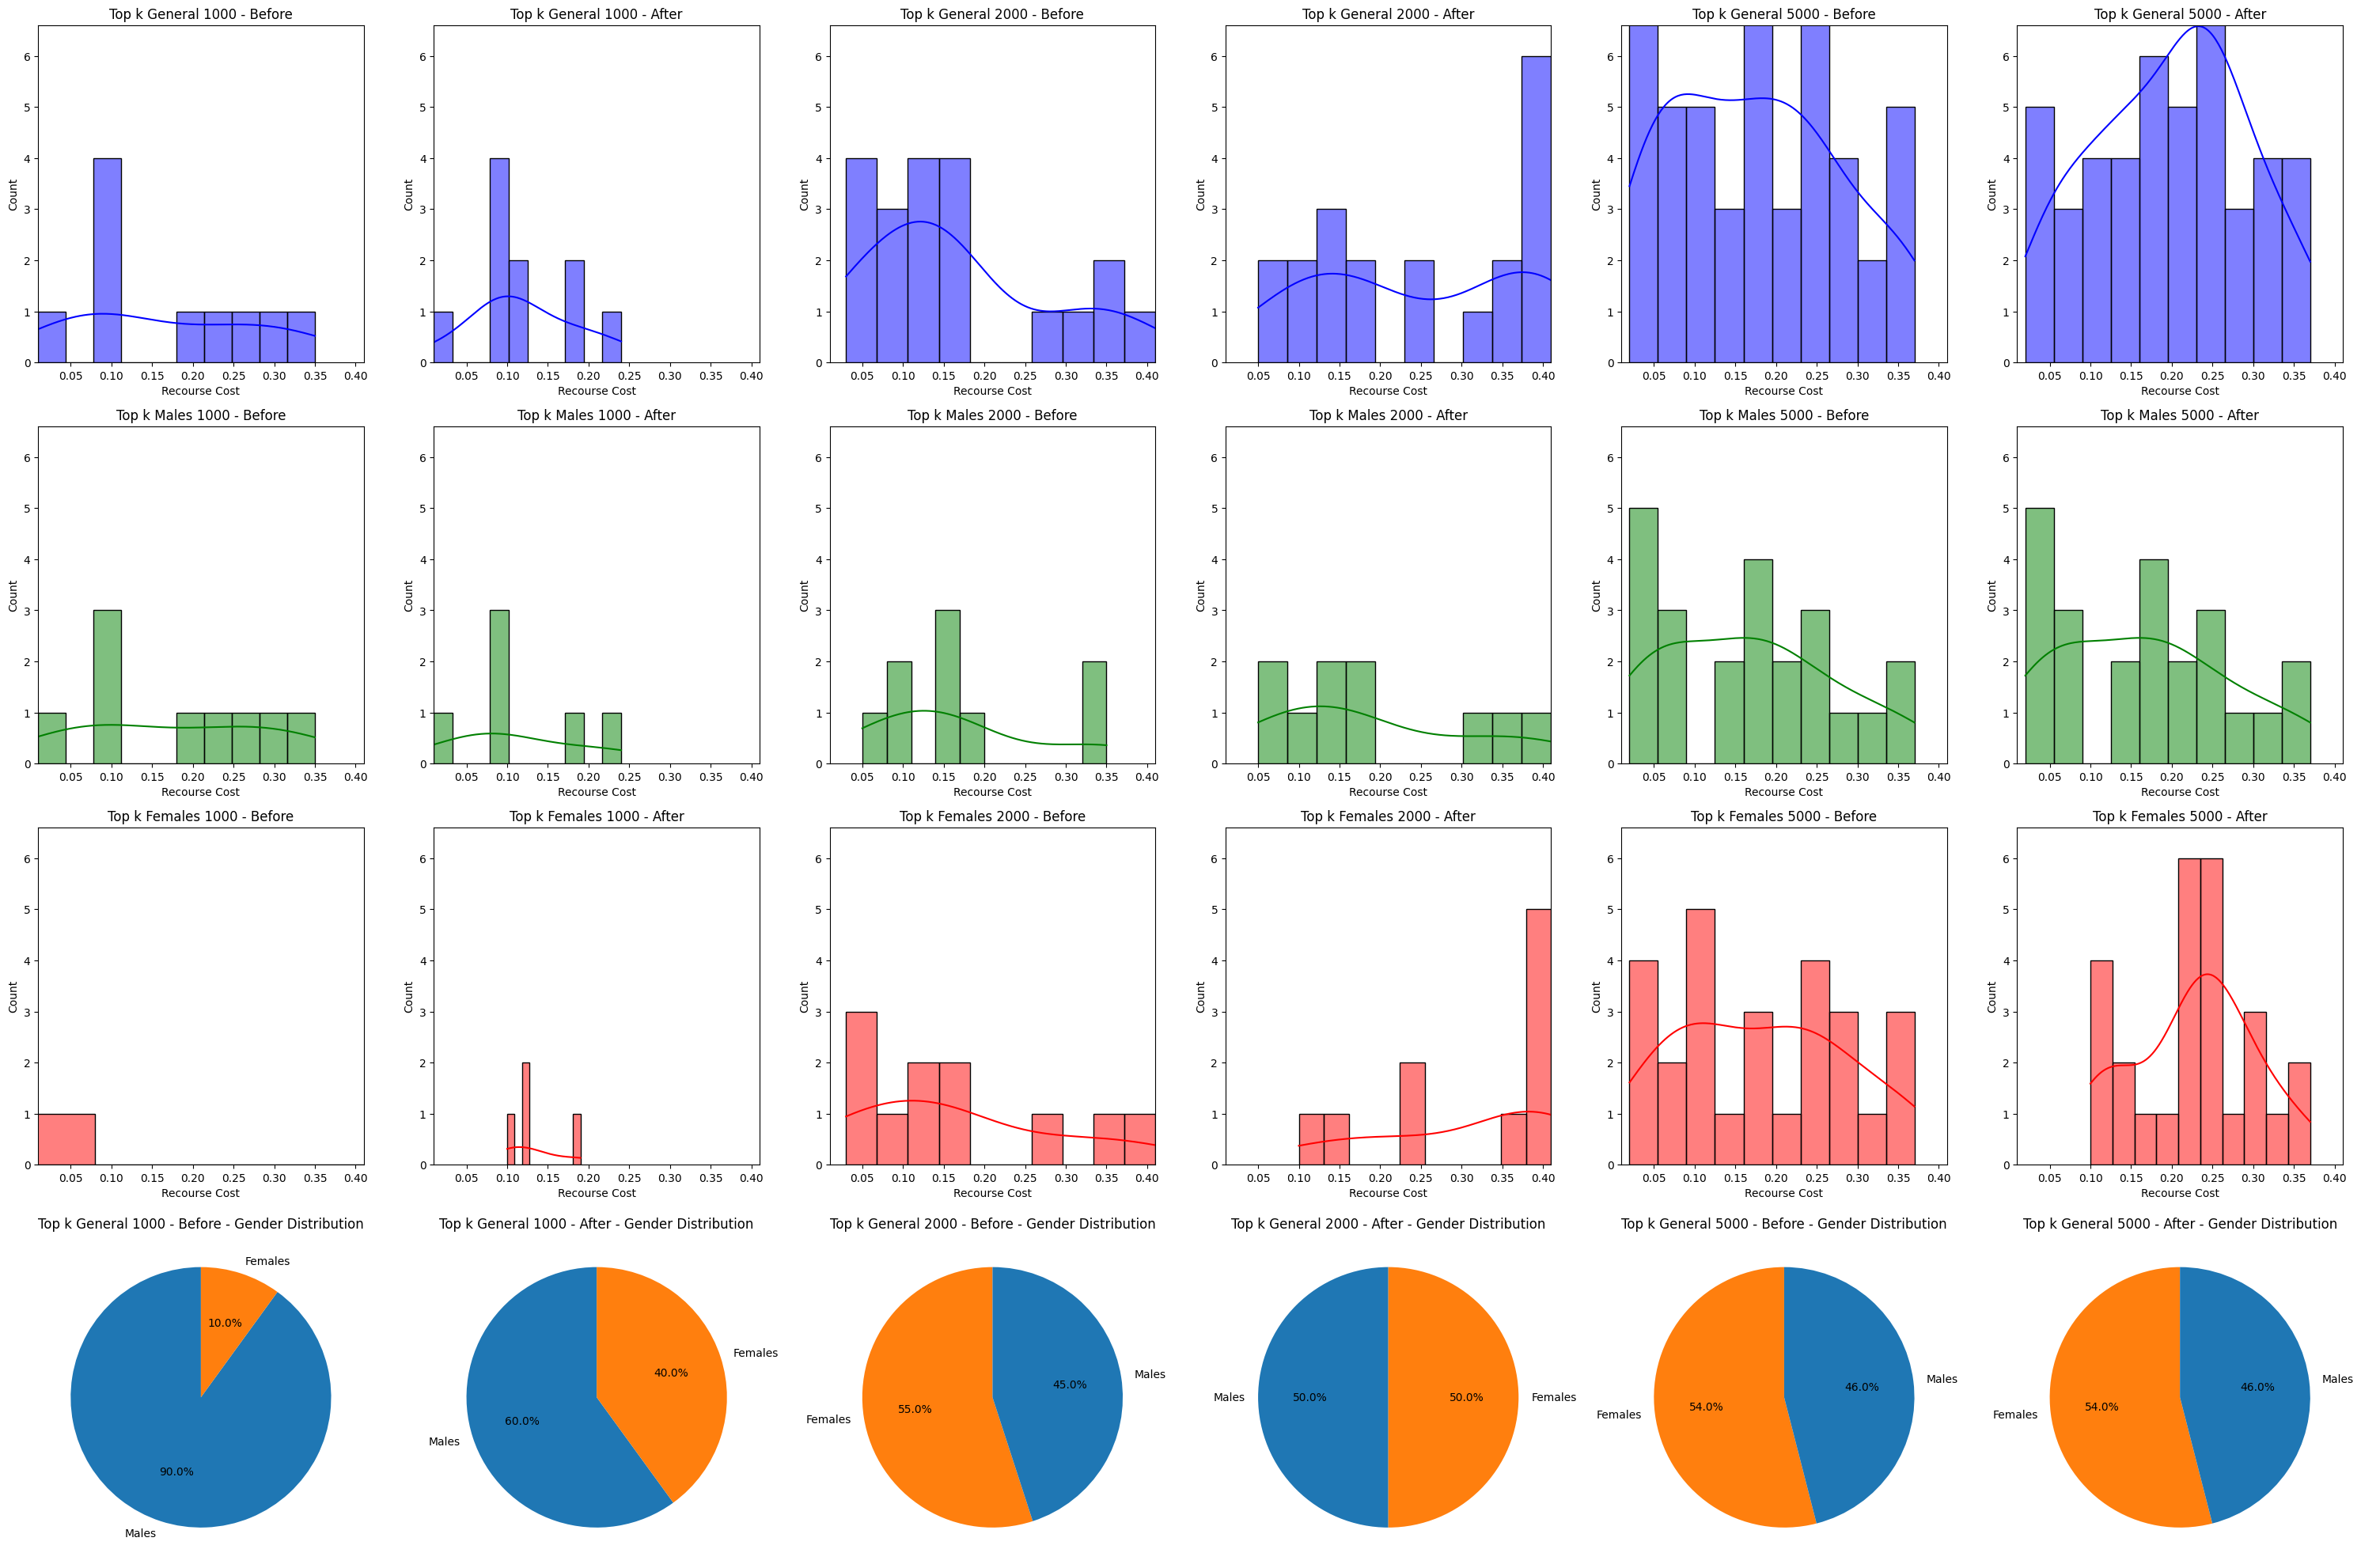

In [8]:
import itertools

distributions1 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('uniform', (30, 60))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

gender_proportions = [0.6, 0.4]

param_grid = {
    'dataset_size': [10000],
    'distributions': [distributions1],  
    'sample_size': [1000,2000,5000],
    'model_type': ['logistic_regression'],
    'percentage_to_help': [0.7],
    'top_k': [10],
    'filepath': ['synthetic_data.csv'],
    'gender_proportions': [gender_proportions]  
}

all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

recourse_without_rewards_list = []
recourse_with_rewards_list = []
top_k_before_after = []
top_k_male_list = []
top_k_female_list = []
top_k_male_before_after = []
top_k_female_before_after = []
male_female_counts_before_after = []

for params in all_params:
    recourse_without_rewards, recourse_with_rewards = experiment(params)

    top_k = int(params['sample_size']/100)

    top_k_before_rewards = recourse_without_rewards.head(top_k)
    top_k_after_rewards = recourse_with_rewards.head(top_k)

    top_k_before_after.append(top_k_before_rewards)
    top_k_before_after.append(top_k_after_rewards)

    top_k_males_before = top_k_before_rewards[top_k_before_rewards['Gender'] == 1]
    top_k_females_before = top_k_before_rewards[top_k_before_rewards['Gender'] == 2]
    top_k_males_after = top_k_after_rewards[top_k_after_rewards['Gender'] == 1]
    top_k_females_after = top_k_after_rewards[top_k_after_rewards['Gender'] == 2]

    top_k_male_before_after.append(top_k_males_before)
    top_k_male_before_after.append(top_k_males_after)

    top_k_female_before_after.append(top_k_females_before)
    top_k_female_before_after.append(top_k_females_after)
    
    male_female_counts_before_after.append((len(top_k_males_before), len(top_k_females_before)))
    male_female_counts_before_after.append((len(top_k_males_after), len(top_k_females_after)))

titles = [
    "Top k General 1000 - Before", "Top k General 1000 - After",
    "Top k General 2000 - Before", "Top k General 2000 - After",
    "Top k General 5000 - Before", "Top k General 5000 - After",
    "Top k Males 1000 - Before", "Top k Males 1000 - After",
    "Top k Males 2000 - Before", "Top k Males 2000 - After",
    "Top k Males 5000 - Before", "Top k Males 5000 - After",
    "Top k Females 1000 - Before", "Top k Females 1000 - After",
    "Top k Females 2000 - Before", "Top k Females 2000 - After",
    "Top k Females 5000 - Before", "Top k Females 5000 - After"
]

plot_custom_grid_of_histograms(top_k_before_after, top_k_male_before_after, top_k_female_before_after, titles)


## Experiment 2

Here, we are changing the original data distribution of X1 for female, and observing the top k data distribution. 

1. Uniform.
2. Normal. 
3. Power law.

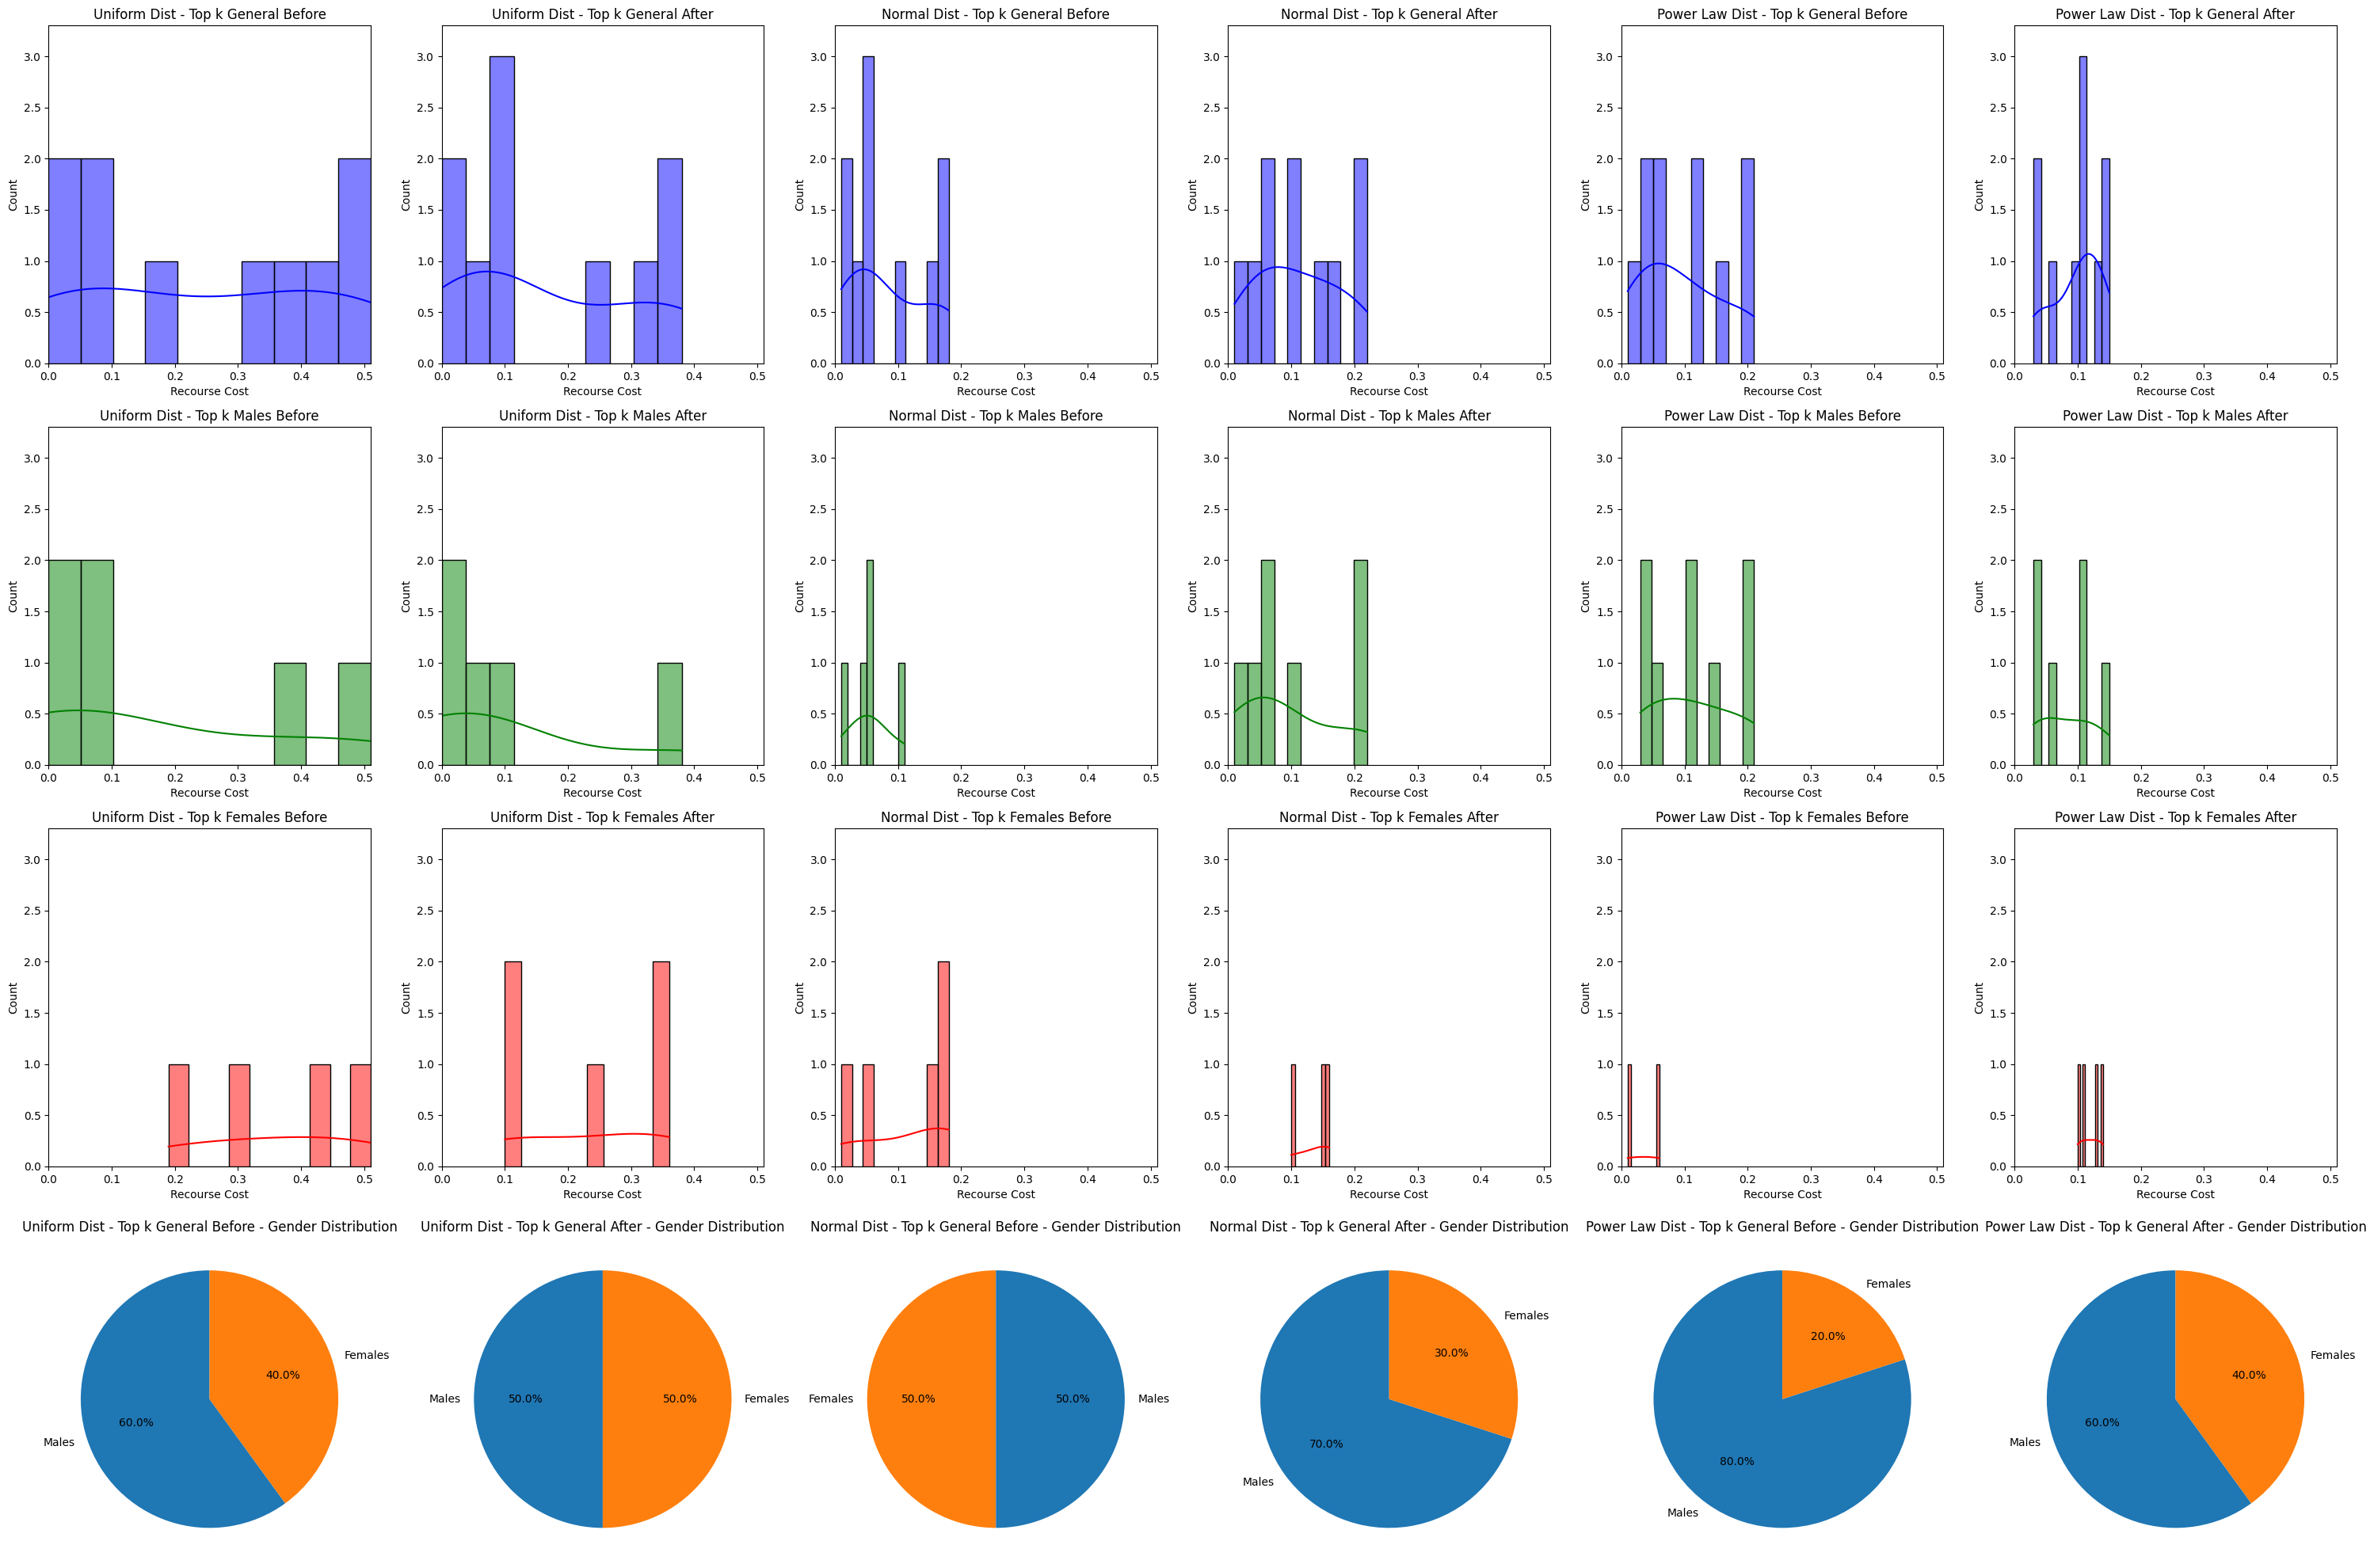

In [13]:
import itertools

distributions1 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('uniform', (30, 60))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

distributions2 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('normal', (30, 60))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

distributions3 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('power_law', (3, 30))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

gender_proportions = [0.6, 0.4]

param_grid = {
    'dataset_size': [10000],
    'distributions': [distributions1, distributions2, distributions3],  
    'sample_size': [1000],
    'model_type': ['logistic_regression'],
    'percentage_to_help': [0.7],
    'top_k': [10],
    'filepath': ['synthetic_data.csv'],
    'gender_proportions': [gender_proportions]  
}

all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

recourse_without_rewards_list = []
recourse_with_rewards_list = []
top_k_before_after = []
top_k_male_list = []
top_k_female_list = []
top_k_male_before_after = []
top_k_female_before_after = []
male_female_counts_before_after = []

for params in all_params:
    recourse_without_rewards, recourse_with_rewards = experiment(params)

    top_k = int(params['sample_size']/100)

    top_k_before_rewards = recourse_without_rewards.head(top_k)
    top_k_after_rewards = recourse_with_rewards.head(top_k)

    top_k_before_after.append(top_k_before_rewards)
    top_k_before_after.append(top_k_after_rewards)

    top_k_males_before = top_k_before_rewards[top_k_before_rewards['Gender'] == 1]
    top_k_females_before = top_k_before_rewards[top_k_before_rewards['Gender'] == 2]
    top_k_males_after = top_k_after_rewards[top_k_after_rewards['Gender'] == 1]
    top_k_females_after = top_k_after_rewards[top_k_after_rewards['Gender'] == 2]

    top_k_male_before_after.append(top_k_males_before)
    top_k_male_before_after.append(top_k_males_after)

    top_k_female_before_after.append(top_k_females_before)
    top_k_female_before_after.append(top_k_females_after)
    
    male_female_counts_before_after.append((len(top_k_males_before), len(top_k_females_before)))
    male_female_counts_before_after.append((len(top_k_males_after), len(top_k_females_after)))

titles = [
    "Uniform Dist - Top k General Before", "Uniform Dist - Top k General After",
    "Normal Dist - Top k General Before", "Normal Dist - Top k General After",
    "Power Law Dist - Top k General Before", "Power Law Dist - Top k General After",
    "Uniform Dist - Top k Males Before", "Uniform Dist - Top k Males After",
    "Normal Dist - Top k Males Before", "Normal Dist - Top k Males After",
    "Power Law Dist - Top k Males Before", "Power Law Dist - Top k Males After",
    "Uniform Dist - Top k Females Before", "Uniform Dist - Top k Females After",
    "Normal Dist - Top k Females Before", "Normal Dist - Top k Females After",
    "Power Law Dist - Top k Females Before", "Power Law Dist - Top k Females After"
]

plot_custom_grid_of_histograms(top_k_before_after, top_k_male_before_after, top_k_female_before_after, titles)



## Experminet 4

Here, we are again changing the sample size and observing the recourse cost distribution before and after applying rewards.

Note: using the base distribution for this experiment.

In [ ]:
import itertools

distributions1 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('uniform', (30, 60))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

gender_proportions = [0.6, 0.4]

param_grid = {
    'dataset_size': [10000],
    'distributions': [distributions1],  
    'sample_size': [1000,2000,3000,4000,5000],
    'model_type': ['logistic_regression'],
    'percentage_to_help': [0.7],
    'top_k': [10],
    'filepath': ['synthetic_data.csv'],
    'gender_proportions': [gender_proportions]  
}

all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

results = []
recourse_without_rewards_list = []
recourse_with_rewards_list = []
top_k_data_list = []

for params in all_params:
    recourse_without_rewards, recourse_with_rewards = experiment(params)

    top_k = int(params['sample_size']/100)
    top_k_data = recourse_with_rewards.head(top_k)

    recourse_without_rewards_list.append(recourse_without_rewards)
    recourse_with_rewards_list.append(recourse_with_rewards)
    top_k_data_list.append(top_k_data)

# plot_side_by_side_histograms(recourse_without_rewards_list,titles=['title1','title2','title3','title4','title5'])
# plot_side_by_side_histograms(recourse_with_rewards_list,titles=['title1','title2','title3','title4','title5'])
plot_side_by_side_histograms(recourse_without_rewards_list,titles=['Sample size 1000', 'Sample size 2000', 'Sample size 3000', 'Sample size 4000', 'Sample size 5000'],
                             legend_labels=['Recourse without Rewards', 'Recourse without Rewards', 'Recourse without Rewards', 'Recourse without Rewards', 'Recourse without Rewards'])
plot_side_by_side_histograms(recourse_with_rewards_list,titles=['Sample size 1000', 'Sample size 2000', 'Sample size 3000', 'Sample size 4000', 'Sample size 5000'],
                             legend_labels=['Recourse with Rewards', 'Recourse with Rewards', 'Recourse with Rewards', 'Recourse with Rewards', 'Recourse with Rewards'])


# male_list = [df[df['Gender'] == 1] for df in top_k_data_list]
# female_list = [df[df['Gender'] == 2] for df in top_k_data_list]

# plot_side_by_side_histograms(top_k_male_list, titles=['Top 10 Male Dist', 'Top 20 Male Dist','Top 30 Male Dist','Top 40 Male Dist','Top 50 Male Dist',])
# plot_side_by_side_histograms(top_k_female_list, titles=['Top 10 Female Dist', 'Top 20 Female Dist','Top 30 Female Dist','Top 40 Female Dist','Top 50 Female Dist',])

plot_gender_pie_charts(recourse_without_rewards_list)
